In [1]:
# all imports
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

import fasttext
import fasttext.util

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


/home/rjn/.conda/envs/cuda/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Step 1 :Data Processing

In [2]:
# # # Download the data
# import gdown
# gdown.download(id="1kWfMHosbwCe9xfURNMrZImcDGEbOfXRu")
# gdown.download(id="18rTuyLtaxdzQwxDzNEIxFSUomBgewcJ3")


Downloading...
From (uriginal): https://drive.google.com/uc?id=1kWfMHosbwCe9xfURNMrZImcDGEbOfXRu
From (redirected): https://drive.google.com/uc?id=1kWfMHosbwCe9xfURNMrZImcDGEbOfXRu&confirm=t&uuid=2769f4a9-bdb3-4612-b867-3908bc079493
To: /home/rjn/Documents/GitHub/Nepali-News-Classification-LR/data.csv
100%|██████████| 268M/268M [00:54<00:00, 4.92MB/s] 
Downloading...
From: https://drive.google.com/uc?id=18rTuyLtaxdzQwxDzNEIxFSUomBgewcJ3
To: /home/rjn/Documents/GitHub/Nepali-News-Classification-LR/suffix.txt
100%|██████████| 5.14k/5.14k [00:00<00:00, 2.35MB/s]


'suffix.txt'

In [3]:
df = pd.read_csv('data.csv')
# First, ensure there are no float values in 'Title'
df = df[~df['Title'].apply(lambda x: isinstance(x, float))]
df = df[~df['News'].apply(lambda x: isinstance(x, float))]

In [4]:
df.head()

,Unnamed: 0,Title,Category,Language,News
0,0,दशगजा क्षेत्रमा अवान्छित गतिविधि हुन नदिने समझ...,राष्ट्रिय समाचार,ne,"१० फागुन, दिल्ली । प्रधानमन्त्री केपी शर्मा ओल..."
1,1,मौरीपालन व्यवसायप्रति किसान आकर्षित,बिजनेस समाचार,ne,"१० फागुन, खोटाङ । जिल्लामा पछिल्लो समय मौरीपाल..."
2,2,जिरीमा पर्यटकको सङ्ख्या बढ्यो,बिजनेस समाचार,ne,"१० फागुन, जिरी। भूकम्पपछि सुनसान बनेको दोलखाको..."
3,3,"आइआइटीमा नेपाली विद्यार्थीलाई अवसर, प्रवेश परी...",बिजनेस समाचार,ne,"१० फागुन, काठमाडौं । तपाईंले स्तरीय विदेशी शैक..."
4,4,यस्तो छ निलम्बनको चेतावनीसहित आइसीसीले नेपालला...,खेलकुद समाचार,ne,"१० फागुन, काठमाडौं । अन्तराष्ट्रिय क्रिकेट काउ..."


**Visaulize total category distribution:**

In [5]:
df_count = df['Category'].value_counts().reset_index()

df_count.columns = ['Category', 'Count']

# Now we can create a bar plot with Plotly
fig = px.bar(df_count, x='Category', y='Count', title='Count of Each Category',color='Category')

# Display the figure
fig.show()

In [6]:
# Now calculate the length of each title
df['TitleLength'] = df['News'].apply(len)

# Create a histogram
fig = px.histogram(df, x="TitleLength", nbins=1000, title='Distribution of Title Lengths')

# Display the figure
fig.show()

In [7]:
# Now filter the DataFrame to only include rows where 'TitleLength' is between 250 and 2600
filtered_df = df[(df['TitleLength'] >= 250) & (df['TitleLength'] <= 2600)]

In [8]:
df_count.head(6)

,Category,Count
0,राष्ट्रिय समाचार,3878
1,देश,3431
2,पत्रपत्रिकाबाट,1465
3,बिजनेस समाचार,1202
4,मनोरञ्जन एप,1093
5,खेलकुद समाचार,954


In [9]:
# Filter the DataFrame to only include rows where 'Category' is in desired_categories

desired_categories = ["खेलकुद समाचार","बिजनेस समाचार","मनोरञ्जन एप","देश"]

filtered_df = df[df['Category'].isin(desired_categories)]

In [10]:
#To balance the categories, you might want to consider downsampling or upsampling.

# Find the smallest category count
smallest_category_count = filtered_df['Category'].value_counts().min()

# Group the DataFrame by 'Category'
grouped = filtered_df.groupby('Category')

# Define a function to do the random sampling
def sample_group(group):
    return group.sample(smallest_category_count)

# Apply the function to each group
sampled = grouped.apply(sample_group)

# Reset the index
balanced_df = sampled.reset_index(drop=True)

In [11]:
# so whats the balanced catetgory ?
df_count = balanced_df['Category'].value_counts().reset_index()
df_count.head()

,index,Category
0,खेलकुद समाचार,954
1,देश,954
2,बिजनेस समाचार,954
3,मनोरञ्जन एप,954


### Step 2: Preprocess the dataset

Text to be celeaned : काठमाडौँभित्र 3%%% दिनभर पानी पर्ने र पोखरालगाएतमा बुटवलमा @ पानी नपर्ने Rajan 💪💪 😢 २४ १४११ १२३१२३२१३

In [12]:
sample_text = "काठमाडौँभित्रRajan 3%%% दिनभर पानी पर्ने र पोखरालगाएतमा बुटवलमा @ पानी नपर्ने Rajan 💪💪 😢 २४ १४११ १२३१२३२१३"



Preprocess

In [13]:
import re

def Devnagari_Extractor(text):
    devanagari_range = r"[\u0900-\u097F\\]"

    text = re.sub("[।]", "", text)
    tokens = text.split(" ")

    filtered = []

    for token in tokens:
        devanagari_chars = []
        for char in token:
            if re.match(devanagari_range, char):
                devanagari_chars.append(char)


        filtered.append("".join(devanagari_chars))

    # there might be multiple white spaces between words 
    cleaned =  " ".join(filtered)

    # get only single white space
    return " ".join(cleaned.split())


In [14]:
Devnagari_Extractor(sample_text)

'काठमाडौँभित्र दिनभर पानी पर्ने र पोखरालगाएतमा बुटवलमा पानी नपर्ने २४ १४११ १२३१२३२१३'

In [15]:
balanced_df['clean_news'] = balanced_df['News'].apply(lambda x: Devnagari_Extractor(x))
balanced_df.head()

,Unnamed: 0,Title,Category,Language,News,TitleLength,clean_news
0,11347,"नयाँ एकदिवसीय लिगको प्रस्ताव, नेपालले टप १० टे...",खेलकुद समाचार,ne,"५ असार, काठमाडौं । अन्तराष्ट्रिय क्रिकेट काउन्...",1671,५ असार काठमाडौं अन्तराष्ट्रिय क्रिकेट काउन्सिल...
1,6624,वेष्ट काठमाडौं नेपालगञ्ज गोल्डकपको सेमिफाइनलमा,खेलकुद समाचार,ne,"१८ वैशाख, नेपालगञ्न । नेपालगञ्ज गोल्डकप फुटबलम...",447,१८ वैशाख नेपालगञ्न नेपालगञ्ज गोल्डकप फुटबलमा व...
2,15478,उडबल टोली मलेसियातर्फ,खेलकुद समाचार,ne,"१५ साउन, काठमाडौं । १९ औं मलेसियन ओपन उडबल च्य...",463,१५ साउन काठमाडौं १९ औं मलेसियन ओपन उडबल च्याम्...
3,13410,२५ वर्षे कान्छी प्रेमिकासँग बिहे गर्दै पेले,खेलकुद समाचार,ne,"२५ असार, काठमाडौं । ब्राजिलियन फुटबल लेजेन्ड प...",747,२५ असार काठमाडौं ब्राजिलियन फुटबल लेजेन्ड पेले...
4,4502,कृष्णमोहन स्मृति खुल्ला ब्याडमिन्टनको उपाधि आर...,खेलकुद समाचार,ne,"२५ चैत, काठमाडौं । त्रिभुवन आर्मी क्लबकी मेघा ...",2013,२५ चैत काठमाडौं त्रिभुवन आर्मी क्लबकी मेघा चन्...


**Stemmer:**

In [16]:
suffix_path = "suffix.txt"


def get_suffix():
    suffix_dict = {}

    # create dict based on lenght of suffix
    with open(suffix_path, "r") as f:
        suffixs = f.read()

    suffixs = suffixs.splitlines()

    # iterate through each suffix
    for suffix in suffixs:
        # get length of each suffix
        suf_len = len(list(suffix))

        # check already in list

        if suf_len not in suffix_dict:
            suffix_dict[suf_len] = [suffix]

        else:
            suffix_dict[suf_len] += [suffix]

    return suffix_dict

In [17]:
suffix = get_suffix()

In [18]:
def remove_suffix(word,suffix):
    for L in 9, 8, 7, 6, 5, 4, 3, 2:
        if len(word) > L + 1:
            for suf in suffix[L]:
                if word.endswith(suf):
                    ans = word[:-L]
                    return ans
    return word  # return the original word if no suffix is found

def process_sentence(sentence, suffix):
    words = sentence.split()
    processed_words = [remove_suffix(word, suffix) for word in words]
    processed_sentence = ' '.join(processed_words)
    return processed_sentence

In [19]:
balanced_df['clean_news_stemmed'] = balanced_df['clean_news'].apply(lambda x: process_sentence(x,suffix = suffix))
balanced_df.head()

,Unnamed: 0,Title,Category,Language,News,TitleLength,clean_news,clean_news_stemmed
0,11347,"नयाँ एकदिवसीय लिगको प्रस्ताव, नेपालले टप १० टे...",खेलकुद समाचार,ne,"५ असार, काठमाडौं । अन्तराष्ट्रिय क्रिकेट काउन्...",1671,५ असार काठमाडौं अन्तराष्ट्रिय क्रिकेट काउन्सिल...,५ असार काठमाडौं अन्तराष्ट्रिय क्रिकेट काउन्सिल...
1,6624,वेष्ट काठमाडौं नेपालगञ्ज गोल्डकपको सेमिफाइनलमा,खेलकुद समाचार,ne,"१८ वैशाख, नेपालगञ्न । नेपालगञ्ज गोल्डकप फुटबलम...",447,१८ वैशाख नेपालगञ्न नेपालगञ्ज गोल्डकप फुटबलमा व...,१८ वैशाख नेपालगञ्न नेपालगञ्ज गोल्डकप फुटबल वेष...
2,15478,उडबल टोली मलेसियातर्फ,खेलकुद समाचार,ne,"१५ साउन, काठमाडौं । १९ औं मलेसियन ओपन उडबल च्य...",463,१५ साउन काठमाडौं १९ औं मलेसियन ओपन उडबल च्याम्...,१५ साउन काठमाडौं १९ औं मलेसियन ओपन उडबल च्याम्...
3,13410,२५ वर्षे कान्छी प्रेमिकासँग बिहे गर्दै पेले,खेलकुद समाचार,ne,"२५ असार, काठमाडौं । ब्राजिलियन फुटबल लेजेन्ड प...",747,२५ असार काठमाडौं ब्राजिलियन फुटबल लेजेन्ड पेले...,२५ असार काठमाडौं ब्राजिलियन फुटबल लेजेन्ड पेले...
4,4502,कृष्णमोहन स्मृति खुल्ला ब्याडमिन्टनको उपाधि आर...,खेलकुद समाचार,ne,"२५ चैत, काठमाडौं । त्रिभुवन आर्मी क्लबकी मेघा ...",2013,२५ चैत काठमाडौं त्रिभुवन आर्मी क्लबकी मेघा चन्...,२५ चैत काठमाडौं त्रिभुवन आर्मी क्लब मेघा चन्द ...


### Train Vectorize Text

In [21]:
# !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ne.300.bin.gz
# !gzip -d /content/cc.ne.300.bin.gz

fasttext.FastText.eprint = lambda x: None
ft_ne = fasttext.load_model(r"cc.ne.300.bin")

In [22]:
balanced_df.head()

,Unnamed: 0,Title,Category,Language,News,TitleLength,clean_news,clean_news_stemmed
0,11347,"नयाँ एकदिवसीय लिगको प्रस्ताव, नेपालले टप १० टे...",खेलकुद समाचार,ne,"५ असार, काठमाडौं । अन्तराष्ट्रिय क्रिकेट काउन्...",1671,५ असार काठमाडौं अन्तराष्ट्रिय क्रिकेट काउन्सिल...,५ असार काठमाडौं अन्तराष्ट्रिय क्रिकेट काउन्सिल...
1,6624,वेष्ट काठमाडौं नेपालगञ्ज गोल्डकपको सेमिफाइनलमा,खेलकुद समाचार,ne,"१८ वैशाख, नेपालगञ्न । नेपालगञ्ज गोल्डकप फुटबलम...",447,१८ वैशाख नेपालगञ्न नेपालगञ्ज गोल्डकप फुटबलमा व...,१८ वैशाख नेपालगञ्न नेपालगञ्ज गोल्डकप फुटबल वेष...
2,15478,उडबल टोली मलेसियातर्फ,खेलकुद समाचार,ne,"१५ साउन, काठमाडौं । १९ औं मलेसियन ओपन उडबल च्य...",463,१५ साउन काठमाडौं १९ औं मलेसियन ओपन उडबल च्याम्...,१५ साउन काठमाडौं १९ औं मलेसियन ओपन उडबल च्याम्...
3,13410,२५ वर्षे कान्छी प्रेमिकासँग बिहे गर्दै पेले,खेलकुद समाचार,ne,"२५ असार, काठमाडौं । ब्राजिलियन फुटबल लेजेन्ड प...",747,२५ असार काठमाडौं ब्राजिलियन फुटबल लेजेन्ड पेले...,२५ असार काठमाडौं ब्राजिलियन फुटबल लेजेन्ड पेले...
4,4502,कृष्णमोहन स्मृति खुल्ला ब्याडमिन्टनको उपाधि आर...,खेलकुद समाचार,ne,"२५ चैत, काठमाडौं । त्रिभुवन आर्मी क्लबकी मेघा ...",2013,२५ चैत काठमाडौं त्रिभुवन आर्मी क्लबकी मेघा चन्...,२५ चैत काठमाडौं त्रिभुवन आर्मी क्लब मेघा चन्द ...


In [23]:
# Drop the specified columns
balanced_df = balanced_df.drop(['Unnamed: 0'], axis=1)

filtered_df = balanced_df[balanced_df['Language'].isin(['ne'])]


In [24]:
filtered_df.head(
)

,Title,Category,Language,News,TitleLength,clean_news,clean_news_stemmed
0,"नयाँ एकदिवसीय लिगको प्रस्ताव, नेपालले टप १० टे...",खेलकुद समाचार,ne,"५ असार, काठमाडौं । अन्तराष्ट्रिय क्रिकेट काउन्...",1671,५ असार काठमाडौं अन्तराष्ट्रिय क्रिकेट काउन्सिल...,५ असार काठमाडौं अन्तराष्ट्रिय क्रिकेट काउन्सिल...
1,वेष्ट काठमाडौं नेपालगञ्ज गोल्डकपको सेमिफाइनलमा,खेलकुद समाचार,ne,"१८ वैशाख, नेपालगञ्न । नेपालगञ्ज गोल्डकप फुटबलम...",447,१८ वैशाख नेपालगञ्न नेपालगञ्ज गोल्डकप फुटबलमा व...,१८ वैशाख नेपालगञ्न नेपालगञ्ज गोल्डकप फुटबल वेष...
2,उडबल टोली मलेसियातर्फ,खेलकुद समाचार,ne,"१५ साउन, काठमाडौं । १९ औं मलेसियन ओपन उडबल च्य...",463,१५ साउन काठमाडौं १९ औं मलेसियन ओपन उडबल च्याम्...,१५ साउन काठमाडौं १९ औं मलेसियन ओपन उडबल च्याम्...
3,२५ वर्षे कान्छी प्रेमिकासँग बिहे गर्दै पेले,खेलकुद समाचार,ne,"२५ असार, काठमाडौं । ब्राजिलियन फुटबल लेजेन्ड प...",747,२५ असार काठमाडौं ब्राजिलियन फुटबल लेजेन्ड पेले...,२५ असार काठमाडौं ब्राजिलियन फुटबल लेजेन्ड पेले...
4,कृष्णमोहन स्मृति खुल्ला ब्याडमिन्टनको उपाधि आर...,खेलकुद समाचार,ne,"२५ चैत, काठमाडौं । त्रिभुवन आर्मी क्लबकी मेघा ...",2013,२५ चैत काठमाडौं त्रिभुवन आर्मी क्लबकी मेघा चन्...,२५ चैत काठमाडौं त्रिभुवन आर्मी क्लब मेघा चन्द ...


In [25]:


# Convert to Vecotr
def get_vector(news_body):
    return ft_ne.get_sentence_vector(news_body).tolist()



# Appending Vecotrs
filtered_df['vector'] = filtered_df['clean_news_stemmed'].apply(lambda x: get_vector(x))
filtered_df.head()



/tmp/ipykernel_16328/1691584904.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Title,Category,Language,News,TitleLength,clean_news,clean_news_stemmed,vector
0,"नयाँ एकदिवसीय लिगको प्रस्ताव, नेपालले टप १० टे...",खेलकुद समाचार,ne,"५ असार, काठमाडौं । अन्तराष्ट्रिय क्रिकेट काउन्...",1671,५ असार काठमाडौं अन्तराष्ट्रिय क्रिकेट काउन्सिल...,५ असार काठमाडौं अन्तराष्ट्रिय क्रिकेट काउन्सिल...,"[0.025762662291526794, -0.002300851047039032, ..."
1,वेष्ट काठमाडौं नेपालगञ्ज गोल्डकपको सेमिफाइनलमा,खेलकुद समाचार,ne,"१८ वैशाख, नेपालगञ्न । नेपालगञ्ज गोल्डकप फुटबलम...",447,१८ वैशाख नेपालगञ्न नेपालगञ्ज गोल्डकप फुटबलमा व...,१८ वैशाख नेपालगञ्न नेपालगञ्ज गोल्डकप फुटबल वेष...,"[0.006536036264151335, 0.01379438117146492, -0..."
2,उडबल टोली मलेसियातर्फ,खेलकुद समाचार,ne,"१५ साउन, काठमाडौं । १९ औं मलेसियन ओपन उडबल च्य...",463,१५ साउन काठमाडौं १९ औं मलेसियन ओपन उडबल च्याम्...,१५ साउन काठमाडौं १९ औं मलेसियन ओपन उडबल च्याम्...,"[0.05640686675906181, 0.01888788677752018, -0...."
3,२५ वर्षे कान्छी प्रेमिकासँग बिहे गर्दै पेले,खेलकुद समाचार,ne,"२५ असार, काठमाडौं । ब्राजिलियन फुटबल लेजेन्ड प...",747,२५ असार काठमाडौं ब्राजिलियन फुटबल लेजेन्ड पेले...,२५ असार काठमाडौं ब्राजिलियन फुटबल लेजेन्ड पेले...,"[0.027292713522911072, -0.004565405659377575, ..."
4,कृष्णमोहन स्मृति खुल्ला ब्याडमिन्टनको उपाधि आर...,खेलकुद समाचार,ne,"२५ चैत, काठमाडौं । त्रिभुवन आर्मी क्लबकी मेघा ...",2013,२५ चैत काठमाडौं त्रिभुवन आर्मी क्लबकी मेघा चन्...,२५ चैत काठमाडौं त्रिभुवन आर्मी क्लब मेघा चन्द ...,"[0.05345058813691139, 0.0038812144193798304, -..."


In [26]:
le = preprocessing.LabelEncoder()
le.fit(filtered_df['Category'])
# see the mapping:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
filtered_df['type']=le.transform(filtered_df['Category'].values)

filtered_df = filtered_df.drop(['Language','TitleLength'], axis=1)

/tmp/ipykernel_16328/1896149982.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [27]:
filtered_df.head()

,Title,Category,News,clean_news,clean_news_stemmed,vector,type
0,"नयाँ एकदिवसीय लिगको प्रस्ताव, नेपालले टप १० टे...",खेलकुद समाचार,"५ असार, काठमाडौं । अन्तराष्ट्रिय क्रिकेट काउन्...",५ असार काठमाडौं अन्तराष्ट्रिय क्रिकेट काउन्सिल...,५ असार काठमाडौं अन्तराष्ट्रिय क्रिकेट काउन्सिल...,"[0.025762662291526794, -0.002300851047039032, ...",0
1,वेष्ट काठमाडौं नेपालगञ्ज गोल्डकपको सेमिफाइनलमा,खेलकुद समाचार,"१८ वैशाख, नेपालगञ्न । नेपालगञ्ज गोल्डकप फुटबलम...",१८ वैशाख नेपालगञ्न नेपालगञ्ज गोल्डकप फुटबलमा व...,१८ वैशाख नेपालगञ्न नेपालगञ्ज गोल्डकप फुटबल वेष...,"[0.006536036264151335, 0.01379438117146492, -0...",0
2,उडबल टोली मलेसियातर्फ,खेलकुद समाचार,"१५ साउन, काठमाडौं । १९ औं मलेसियन ओपन उडबल च्य...",१५ साउन काठमाडौं १९ औं मलेसियन ओपन उडबल च्याम्...,१५ साउन काठमाडौं १९ औं मलेसियन ओपन उडबल च्याम्...,"[0.05640686675906181, 0.01888788677752018, -0....",0
3,२५ वर्षे कान्छी प्रेमिकासँग बिहे गर्दै पेले,खेलकुद समाचार,"२५ असार, काठमाडौं । ब्राजिलियन फुटबल लेजेन्ड प...",२५ असार काठमाडौं ब्राजिलियन फुटबल लेजेन्ड पेले...,२५ असार काठमाडौं ब्राजिलियन फुटबल लेजेन्ड पेले...,"[0.027292713522911072, -0.004565405659377575, ...",0
4,कृष्णमोहन स्मृति खुल्ला ब्याडमिन्टनको उपाधि आर...,खेलकुद समाचार,"२५ चैत, काठमाडौं । त्रिभुवन आर्मी क्लबकी मेघा ...",२५ चैत काठमाडौं त्रिभुवन आर्मी क्लबकी मेघा चन्...,२५ चैत काठमाडौं त्रिभुवन आर्मी क्लब मेघा चन्द ...,"[0.05345058813691139, 0.0038812144193798304, -...",0


In [28]:
X = filtered_df['vector'].to_numpy()
X = X.reshape(-1, 1)
X = np.concatenate(np.concatenate(X, axis = 0), axis = 0).reshape(-1, 300)
X.shape
y = filtered_df['type'].values

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)
X_train.shape, X_test.shape

((3048, 300), (763, 300))

## Logestic Regression Train

In [30]:

import numpy as np


class LogisticRegression:
    def __init__(self, lr=0.00001, n_iter=1000):
        self.lr = lr
        self.n_iter = n_iter
        self.w = None

    @staticmethod
    def one_hot(y):
        n_classes = np.unique(y)
        one_hot = np.zeros((len(y), len(n_classes)))
        for i, c in enumerate(y):
            one_hot[i, n_classes == c] = 1
        return one_hot

    def probabilities(self, X):
        z = np.dot(X, self.w.T)
        return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)

    def predict(self, X):
        X = np.insert(X, 0, 1, axis=1)
        return np.argmax(self.probabilities(X), axis=1)

    def accuracy(self, X, y):
        return np.mean(self.predict(X) == y)

    def fit(self, X, y):
        X = np.insert(X, 0, 1, axis=1) # (samples,dim) -> (samples, dim + 1)
        self.w = np.zeros((len(np.unique(y)), X.shape[1])) # (4, 301)
        y = self.one_hot(y)

        for _ in range(self.n_iter):
            predictions = self.probabilities(X)
            error = predictions - y
            gradient = np.dot(error.T, X)
            self.w -= self.lr * gradient




In [31]:
lr = LogisticRegression(n_iter=5000)
lr.fit(X_train, y_train)

------------------------------------------------------------
Training Accuracy :  88.4514435695538%
------------------------------------------------------------
Testing Accuracy :  88.72870249017038%
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       191
           1       0.86      0.77      0.81       190
           2       0.79      0.88      0.83       191
           3       0.95      0.95      0.95       191

    accuracy                           0.89       763
   macro avg       0.89      0.89      0.89       763
weighted avg       0.89      0.89      0.89       763

------------------------------------------------------------


(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, '0'), Text(0, 1.5, '1'), Text(0, 2.5, '2'), Text(0, 3.5, '3')])

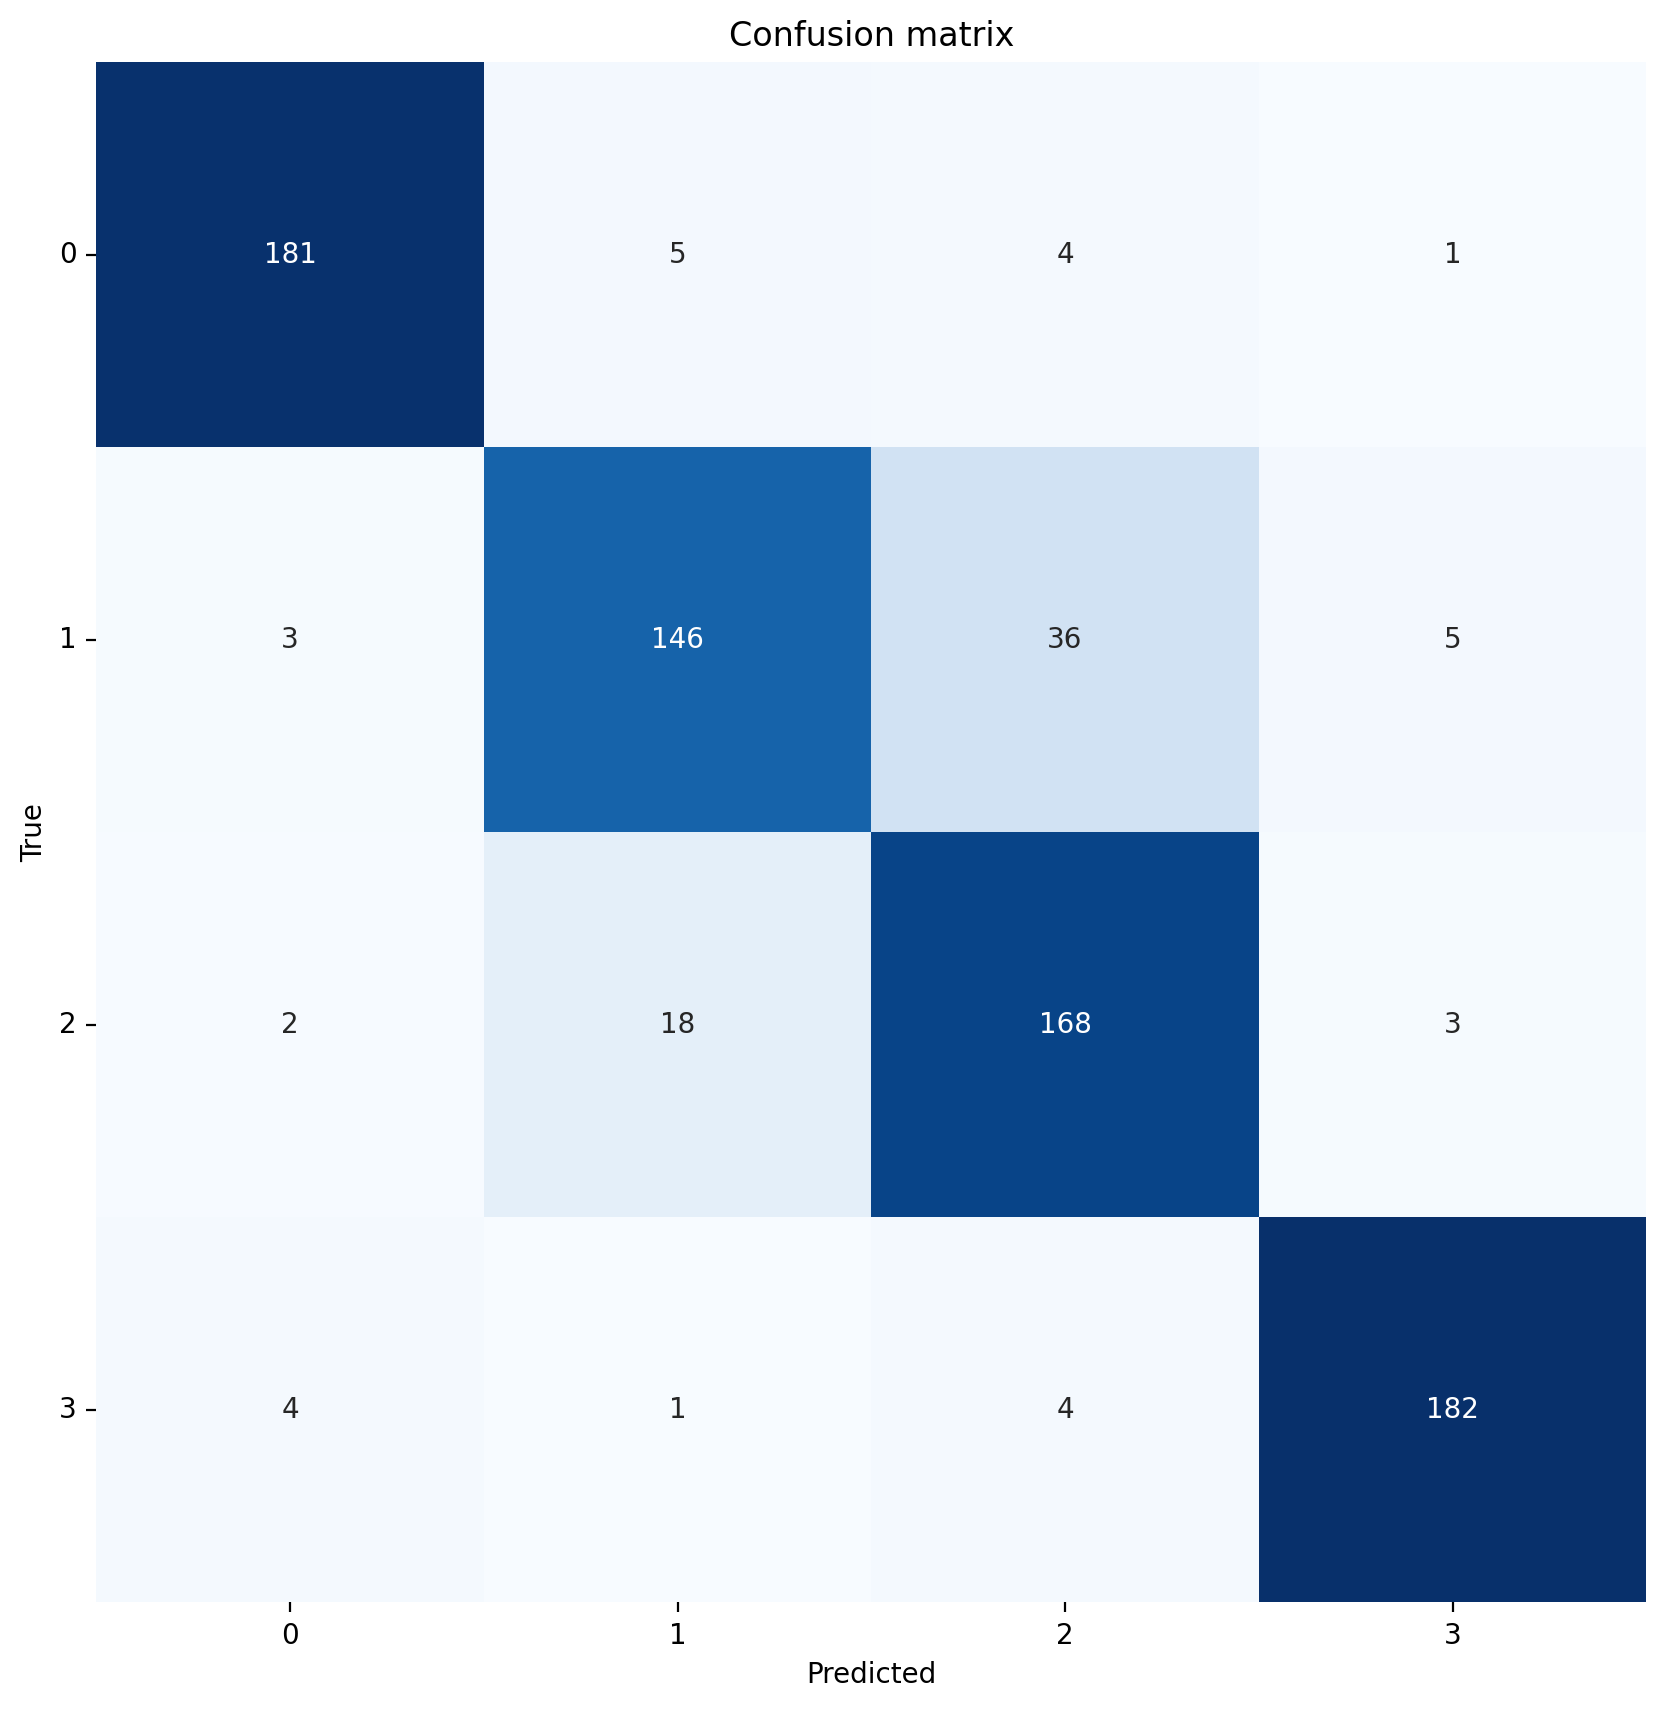

In [32]:
print('-' * 60)
print(f'Training Accuracy :  {lr.accuracy(X_train,y_train) * 100 }%')
print('-' * 60)
y_pred = lr.predict(X_test)
print(f'Testing Accuracy :  {(y_pred==y_test).mean() * 100 }%')
print('-' * 60)
print(classification_report(y_test, y_pred))
print('-' * 60)
classes = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10) , dpi = 100)
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues,
            cbar=False)
ax.set(xlabel="Predicted", ylabel="True", xticklabels= classes,
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

## Train NN

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# convert your numpy arrays to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)  # As y is label, usually we use torch.long type

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# construct the datasets
train_dataset = TextDataset(X_train, y_train)
test_dataset = TextDataset(X_test, y_test)

# construct the dataloaders
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

input_dim = 300
hidden_dim = 100
num_classes = len(le_name_mapping)
output_dim = num_classes  # for 3 classes

model = FFNN(input_dim, hidden_dim, output_dim)

# Cross Entropy Loss for multi-class classification
criterion = nn.CrossEntropyLoss()

# Stochastic Gradient Descent optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)


In [ ]:
# lists to store per-epoch loss and accuracy values
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

num_epochs = 100  # adjust as needed

for epoch in range(num_epochs):
    train_epoch_losses = []  # store each batch's loss for this epoch
    train_epoch_accuracies = []  # store each batch's accuracy for this epoch
    test_epoch_losses = []
    test_epoch_accuracies = []

    # Training Phase
    model.train()
    for i, (texts, labels) in enumerate(train_dataloader):
        labels = labels.long()

        # Forward pass
        outputs = model(texts)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)  # get class predictions
        correct = (predicted == labels).sum().item()  # count correct predictions
        accuracy = correct / labels.size(0)

        train_epoch_losses.append(loss.item())
        train_epoch_accuracies.append(accuracy)

    # Testing Phase
    model.eval()
    with torch.no_grad():
        for i, (texts, labels) in enumerate(test_dataloader):
            labels = labels.long()

            # Forward pass
            outputs = model(texts)
            loss = criterion(outputs, labels)

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)  # get class predictions
            correct = (predicted == labels).sum().item()  # count correct predictions
            accuracy = correct / labels.size(0)

            test_epoch_losses.append(loss.item())
            test_epoch_accuracies.append(accuracy)

    # Record average loss and accuracy for this epoch
    train_losses.append(sum(train_epoch_losses) / len(train_epoch_losses))
    train_accuracies.append(sum(train_epoch_accuracies) / len(train_epoch_accuracies))
    test_losses.append(sum(test_epoch_losses) / len(test_epoch_losses))
    test_accuracies.append(sum(test_epoch_accuracies) / len(test_epoch_accuracies))

    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.4f}')

# plot losses
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
plt.plot(test_losses, label='Test Loss', color='green', linewidth=2)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Loss per Epoch', fontsize=14)
plt.legend()
plt.grid(True)

# plot accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='darkorange', linewidth=2)
plt.plot(test_accuracies, label='Test Accuracy', color='purple', linewidth=2)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Accuracy per Epoch', fontsize=14)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
